In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

batch_size = 8
learning_rate = 1e-4
epochs = 10

model_type = "MiDaS_small"
model = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print()

Using cache found in C:\Users\email/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\email/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


figuring out the self supervised training loop with pose estimation is hard, there are a bunch of different papers that implement their own version of it
stil working on getting that set up
meanwhile:

make rgb depth dataloader
write rgb-depth training loop

make rgb semantic dataloader
write rgb-semantic training loop

figure out where to split model into encoder and decoder



In [2]:
import os
from torchvision.transforms import v2
from PIL import Image
import cv2

class Dataset(torch.utils.data.Dataset):
    def __init__(self, model_type, path1, path2):
        internal_image_path_1 = os.path.join(r'Scene01\15-deg-left\frames', path1.split('_')[-1], 'Camera_0')
        internal_image_path_2 = os.path.join(r'Scene01\15-deg-left\frames', path2.split('_')[-1], 'Camera_0')
        self.path1 = os.path.join(path1, internal_image_path_1)
        self.path2 = os.path.join(path2, internal_image_path_2)
        
        file_map1 = {}
        for f in os.listdir(self.path1):
            try:
                index = int(f.split('_')[1].split('.')[0])
            except:
                print(f)
            file_map1[index] = (os.path.join(self.path1, f))
        self.file_map1 = file_map1

        file_map2 = {}
        for f in os.listdir(self.path2):
            try:
                index = int(f.split('_')[1].split('.')[0])
            except:
                print(f)
            file_map2[index] = (os.path.join(self.path2, f))
        self.file_map2 = file_map2

        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        if model_type == 'DPT_large':
            self.transform = midas_transforms.dpt_transform 
        elif model_type == 'MiDaS_small':
            self.transform = midas_transforms.small_transform 

    def __getitem__(self, i):
        # rgb input
        img1 = cv2.imread(self.file_map1[i])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        rgb = self.transform(img1) # already has batch dimension

        img2 = Image.open(self.file_map2[i])
        convert_tensor = v2.Compose(
            [
                v2.Resize(rgb.shape[-2:]),
                v2.ToImageTensor()
            ]

        )
        depth = convert_tensor(img2)[None,:,:,:]

        return rgb, depth

    def __len__(self):
        return len(os.listdir(self.path1))

depth = r'D:\scalable_analytics_institute\semantic_depth_transformer\data\virtual_kitti\vkitti_2.0.3_depth'
rgb = r'D:\scalable_analytics_institute\semantic_depth_transformer\data\virtual_kitti\vkitti_2.0.3_rgb'
semantic = r'D:\scalable_analytics_institute\semantic_depth_transformer\data\virtual_kitti\vkitti_2.0.3_classSegmentation'

rgb_depth_dataset = Dataset(model_type, rgb, depth)

# the transforms provided by the midas torch hub already add the batch dimension to the image, so we need to define the collate function
# in the dataloader manually to accomodate for this.
def collate(batch):
    return torch.cat([item[0] for item in batch], dim = 0), torch.cat([item[1] for item in batch], dim = 0)

rgb_depth_dataloader = DataLoader(rgb_depth_dataset, batch_size=32, collate_fn=collate)  


c:\Users\email\anaconda3\envs\ml\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\email\anaconda3\envs\ml\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

In [3]:
# verify sizes of the images are correct
print(rgb_depth_dataset[0][0].shape)
print(rgb_depth_dataset[0][1].shape)

torch.Size([1, 3, 64, 256])
torch.Size([1, 1, 64, 256])


In [4]:
# verify that the batches have the correct dimension
x = next(iter(rgb_depth_dataloader))
print(x[0].shape)
print(x[1].shape)

torch.Size([32, 3, 64, 256])
torch.Size([32, 1, 64, 256])


0.0
1.0


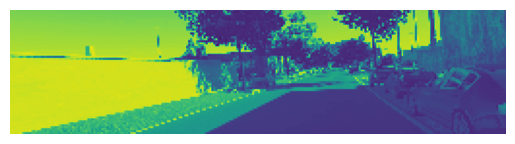

0.0
1.0


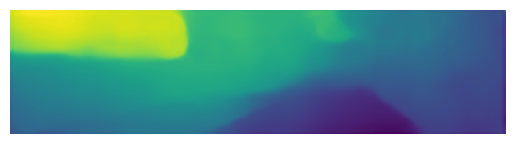

0.0
1.0


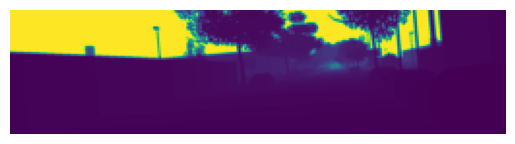

In [5]:
import matplotlib.pyplot as plt
import numpy as np
scale = lambda x : (x - np.min(x)) / (np.max(x) - np.min(x))

for epoch in range(epochs):
    total_loss = 0.0
    model.train()

    for batch_idx, (rgb, depth) in enumerate(rgb_depth_dataloader):
        rgb, depth = rgb.to(device), depth.to(device)

        # Forward pass
        predicted_depth = model(rgb)
        depth = depth.squeeze(1)  
        x = predicted_depth - depth

        # prediction = torch.nn.functional.interpolate(
        #     predicted_depth.unsqueeze(1),
        #     size=img.shape[:2],
        #     mode="bicubic",
        #     align_corners=False,
        # ).squeeze()


        output = rgb[0,0,:,:].detach().cpu().numpy()
        output = scale(output)
        print(np.min(output))
        print(np.max(output))
        plt.imshow(output)
        plt.axis('off')
        plt.show()

        output = predicted_depth[0,:,:].detach().cpu().numpy()
        output = 1 - scale(output)
        print(np.min(output))
        print(np.max(output))
        plt.imshow(output)
        plt.axis('off')
        plt.show()

        output = depth[0,:,:].detach().cpu().numpy()
        output = scale(output)
        print(np.min(output))
        print(np.max(output))
        plt.imshow(output)
        plt.axis('off')
        plt.show()

        break
    break
        
        # loss = criterion(predicted_depth, depth_gt)

        # # Backpropagation and optimization
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()

        # total_loss += loss.item()

        # if (batch_idx + 1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item()}")

    # # Print average loss for the epoch
    # average_loss = total_loss / len(dataloader)
    # print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {average_loss}")

# Save the trained model
# torch.save(model.state_dict(), "./models/depth_estimation_model.pth")
